In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import warnings
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import PolynomialFeatures

# Data Loading

In [2]:
raw_data= pd.read_csv("./turnover.csv",keep_default_na=False,na_values=['_'])

# Data preperation

In [3]:
raw_data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [4]:
raw_data.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [5]:
raw_data.isnull().values.any()

False

In [6]:
raw_data[['sales', 'salary']].describe().T

,count,unique,top,freq
sales,14999,10,sales,4140
salary,14999,3,low,7316


In [7]:
transformed_data=raw_data.copy()

In [8]:
def numerical_features(df):
    columns=df.columns
    return df._get_numeric_data().columns

In [9]:
def categorical_features(df):
    numerical_columns=numerical_features(df)
    return(list(set(df.columns)-set(numerical_columns)))

In [10]:
def onehot_encode(df):
    numericals = df.get(numerical_features(df))
    new_df = numericals.copy()
    for categorical_column in categorical_features(df):
        new_df = pd.concat([new_df, 
                            pd.get_dummies(df[categorical_column], 
                                           prefix=categorical_column)], 
                           axis=1)
    return new_df

In [11]:
numerical_features(transformed_data)

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years'],
      dtype='object')

In [12]:
categorical_features(transformed_data)

['salary', 'sales']

In [13]:
transformed_data=onehot_encode(transformed_data)

In [14]:
scaler = MinMaxScaler()
transformed_data[['satisfaction_level','last_evaluation','number_project',
                  'average_montly_hours','time_spend_company']] = scaler.fit_transform(
                   transformed_data[['satisfaction_level','last_evaluation','number_project',
                  'average_montly_hours','time_spend_company']])

In [15]:
transformed_data.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'salary_high', 'salary_low', 'salary_medium',
       'sales_IT', 'sales_RandD', 'sales_accounting', 'sales_hr',
       'sales_management', 'sales_marketing', 'sales_product_mng',
       'sales_sales', 'sales_support', 'sales_technical'],
      dtype='object')

In [16]:
for i in transformed_data.columns:
    print(transformed_data.dtypes[i])

float64
float64
float64
float64
float64
int64
int64
int64
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


In [17]:
for i in transformed_data.columns:
    if transformed_data.dtypes[i]=='int64' or transformed_data.dtypes[i]=='uint8':
        transformed_data[i] = pd.Categorical(transformed_data[i])

In [18]:
for i in transformed_data.columns:
    print(transformed_data.dtypes[i])

float64
float64
float64
float64
float64
category
category
category
category
category
category
category
category
category
category
category
category
category
category
category
category


# Data Exploration

In [19]:
transformed_data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary_high,salary_low,...,sales_IT,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical
0,0.318681,0.265625,0.0,0.285047,0.125,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,0.780220,0.781250,0.6,0.775701,0.500,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.021978,0.812500,1.0,0.822430,0.250,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.692308,0.796875,0.6,0.593458,0.375,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,0.307692,0.250000,0.0,0.294393,0.125,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0


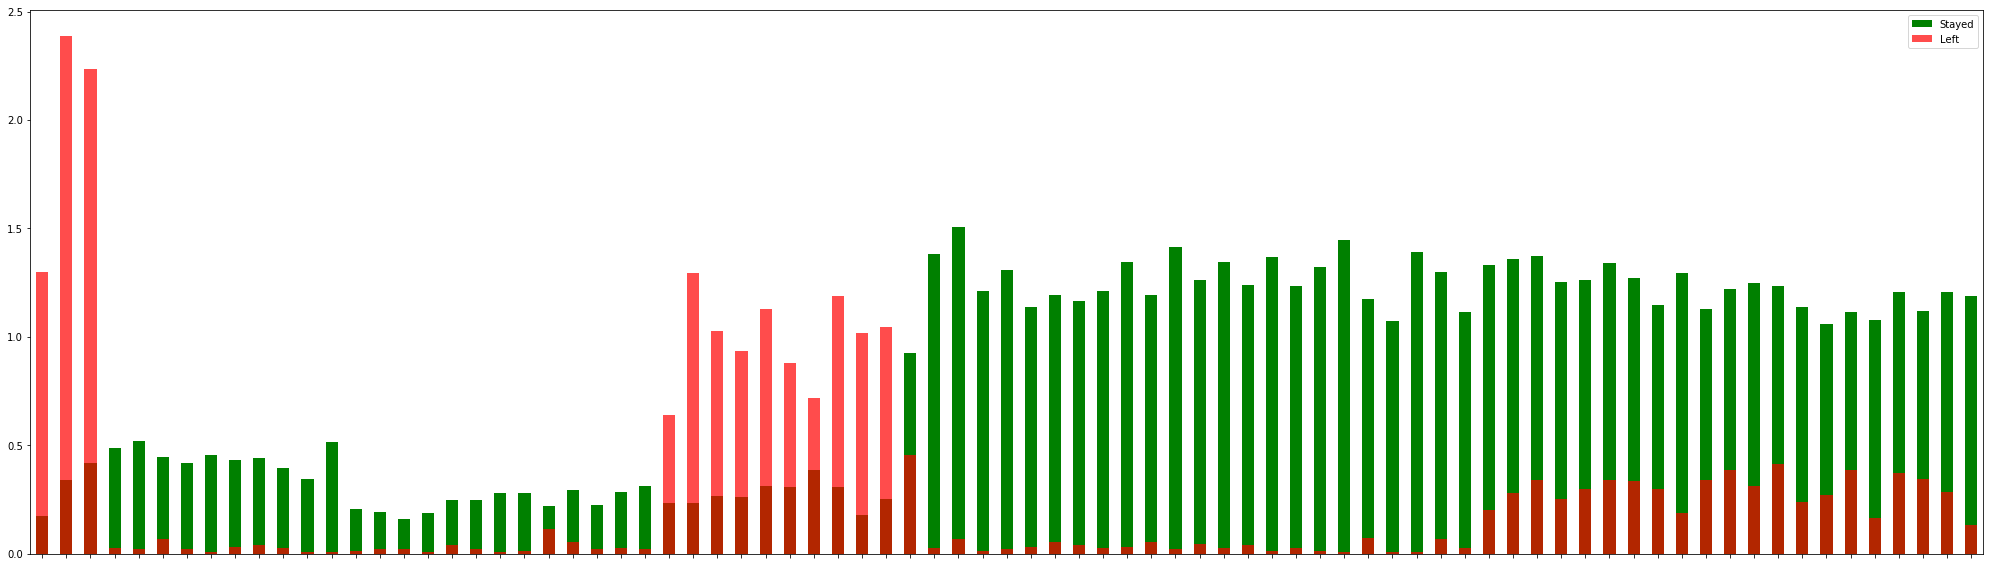

In [20]:
ax=pd.Series((transformed_data[transformed_data.left==0].satisfaction_level.value_counts()/len(transformed_data.left))*100).sort_index().plot(kind='bar',color='g',figsize=(35,10))
pd.Series((transformed_data[transformed_data.left==1].satisfaction_level.value_counts()/len(transformed_data.left))*100).sort_index().plot(kind='bar', color='r',alpha= 0.7,figsize=(35,10), ax=ax)
ax.legend(["Stayed", "Left"])
ax.xaxis.set_major_formatter(plt.NullFormatter())
plt.savefig("satisfaction_level.png")

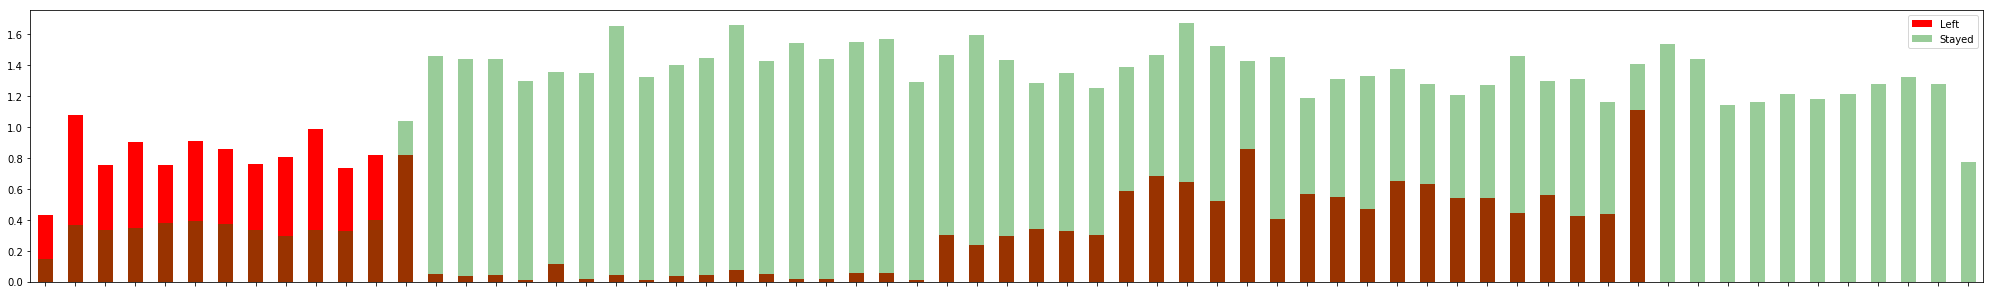

In [21]:
ax=((transformed_data[transformed_data.left==1].last_evaluation.value_counts().sort_index()/len(transformed_data.left))*100).plot(kind='bar',color='r',figsize=(35,5))
((transformed_data[transformed_data.left==0].last_evaluation.value_counts().sort_index()/len(transformed_data.left))*100).plot(kind='bar',color='g',alpha=0.4,figsize=(35,5),ax=ax)
ax.legend(["Left", "Stayed"])
ax.xaxis.set_major_formatter(plt.NullFormatter())
plt.savefig("Last_Evaluation.png")

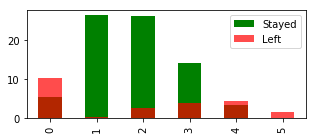

In [22]:
ax=((transformed_data[transformed_data.left==0].number_project.value_counts().sort_index()/len(transformed_data.left))*100).plot(kind='bar',color='g',figsize=(5,2))
((transformed_data[transformed_data.left==1].number_project.value_counts().sort_index()/len(transformed_data.left))*100).plot(kind='bar',color='r',alpha=0.7,figsize=(5,2),ax=ax)
ax.legend(["Stayed", "Left"])
ax.xaxis.set_major_formatter(mtick.ScalarFormatter())
plt.savefig("Number_Projects.png")

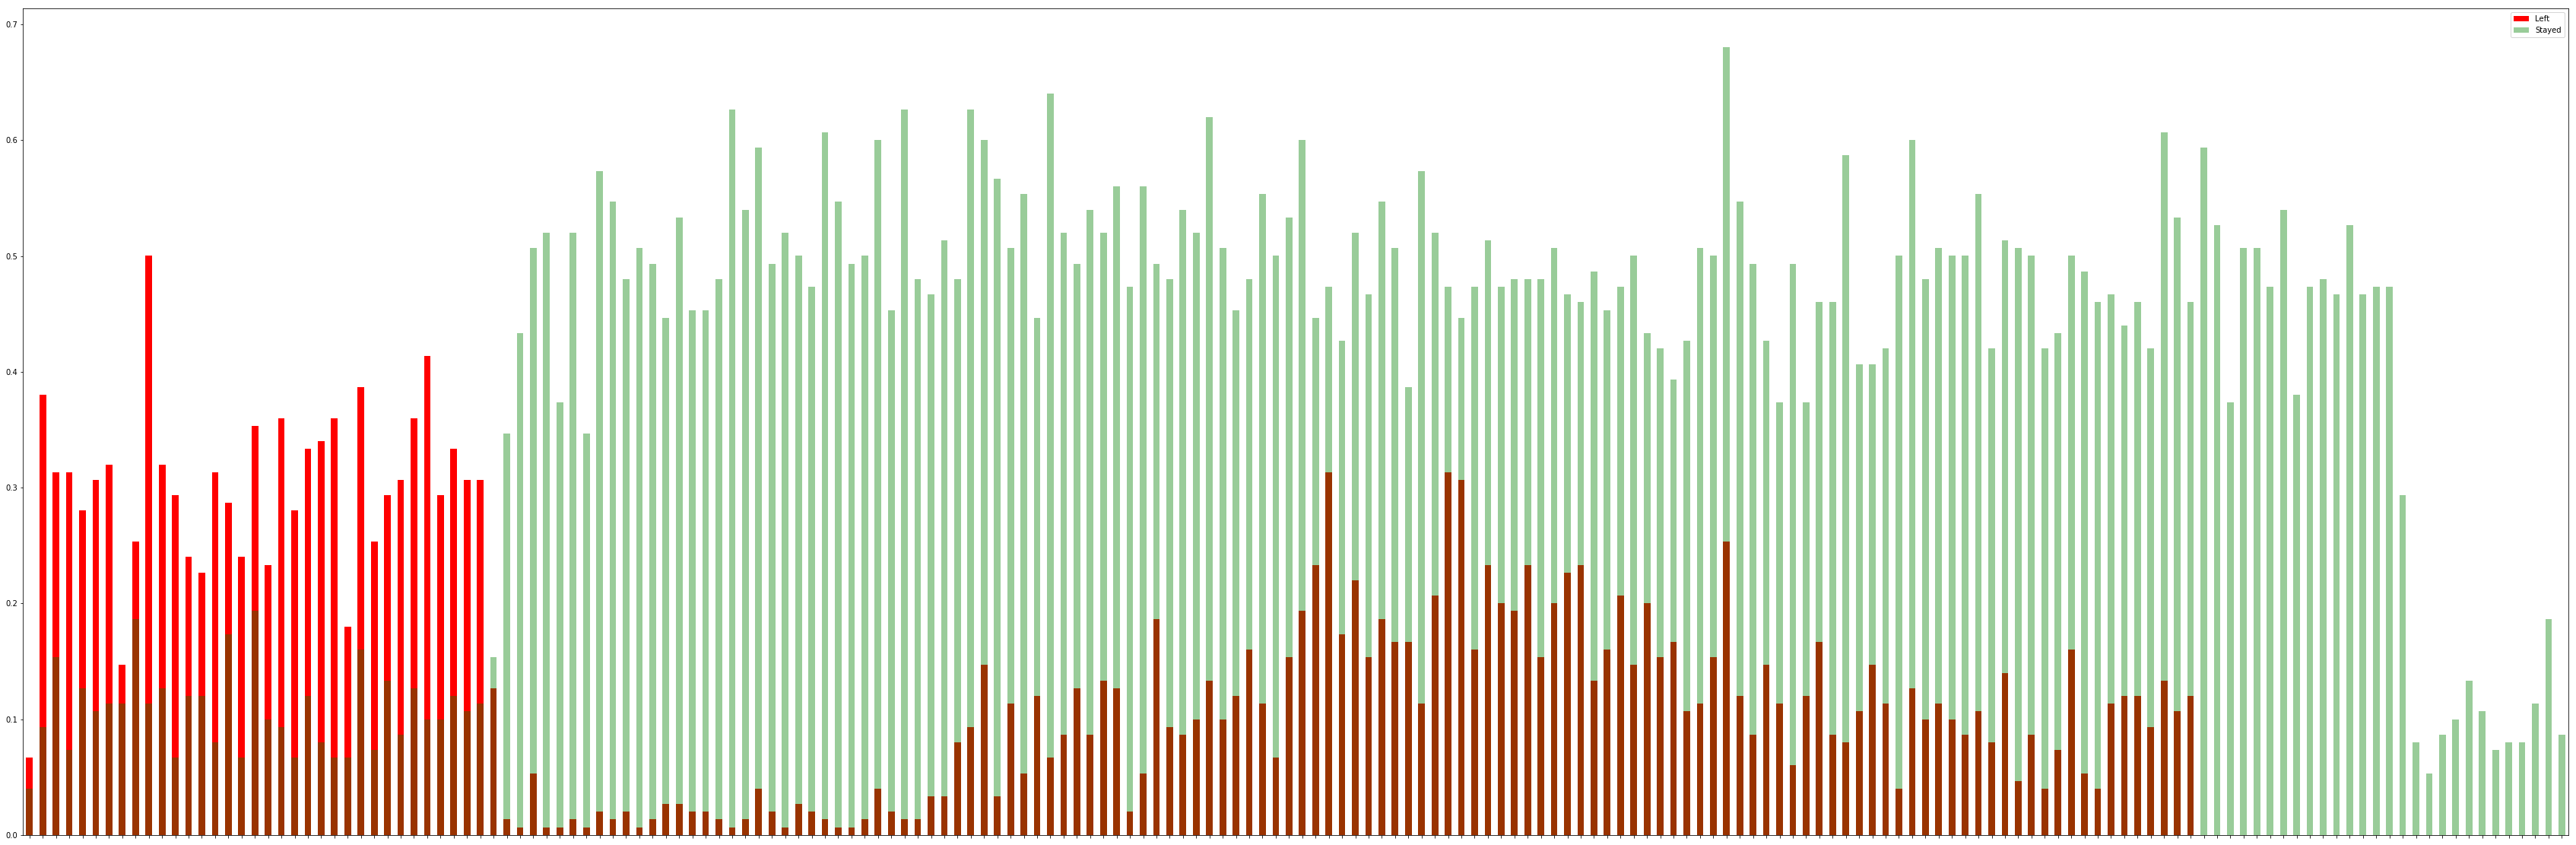

In [23]:
ax=((transformed_data[transformed_data.left==1].average_montly_hours.value_counts().sort_index()/len(transformed_data.left))*100).plot(kind='bar',color='r',figsize=(60,20))
((transformed_data[transformed_data.left==0].average_montly_hours.value_counts().sort_index()/len(transformed_data.left))*100).plot(kind='bar',color='g',alpha=0.4,figsize=(60,20),ax=ax)
ax.legend(["Left", "Stayed"])
ax.xaxis.set_major_formatter(plt.NullFormatter())
plt.savefig("Average_Monthly_Hours.png")

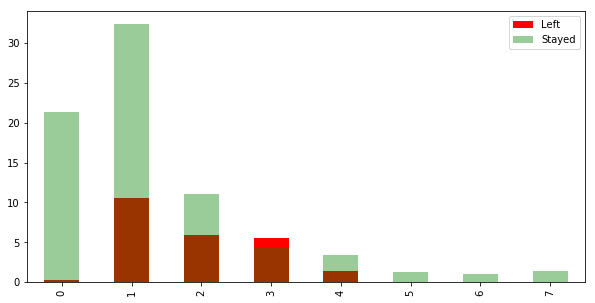

In [24]:
ax=((transformed_data[transformed_data.left==1].time_spend_company.value_counts().sort_index()/len(transformed_data.left))*100).plot(kind='bar',color='r',figsize=(10,5))
((transformed_data[transformed_data.left==0].time_spend_company.value_counts().sort_index()/len(transformed_data.left))*100).plot(kind='bar',color='g',alpha=0.4,figsize=(10,5),ax=ax)
ax.legend(["Left", "Stayed"])
ax.xaxis.set_major_formatter(mtick.ScalarFormatter())
plt.savefig("Time_Spend_Company.png")

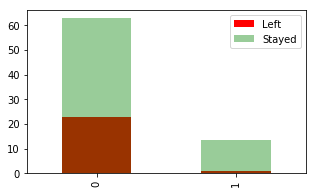

In [25]:
ax=((transformed_data[transformed_data.left==1].Work_accident.value_counts().sort_index()/len(transformed_data.left))*100).plot(kind='bar',color='r',figsize=(5,3))
((transformed_data[transformed_data.left==0].Work_accident.value_counts().sort_index()/len(transformed_data.left))*100).plot(kind='bar',color='g',alpha=0.4,figsize=(5,3),ax=ax)
ax.legend(["Left", "Stayed"])
ax.xaxis.set_major_formatter(mtick.ScalarFormatter())
plt.savefig("Work_Accident.png")

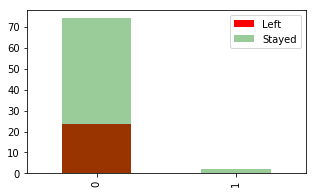

In [26]:
ax=((transformed_data[transformed_data.left==1].promotion_last_5years.value_counts().sort_index()/len(transformed_data.left))*100).plot(kind='bar',color='r',figsize=(5,3))
((transformed_data[transformed_data.left==0].promotion_last_5years.value_counts().sort_index()/len(transformed_data.left))*100).plot(kind='bar',color='g',alpha=0.4,figsize=(5,3),ax=ax)
ax.legend(["Left", "Stayed"])
ax.xaxis.set_major_formatter(mtick.ScalarFormatter())
plt.savefig("Promotion.png")

# Baseline Model

In [27]:
Explanatory = transformed_data.loc[:, transformed_data.columns != 'left']
Target = np.ravel(transformed_data.loc[:, transformed_data.columns == 'left'])

In [28]:
Model=LogisticRegressionCV(cv=5).fit(Explanatory,Target)
Model.score(Explanatory,Target)

0.7845856390426028

# Feature Engineering

In [29]:
def sats_trans(df):
    bins = [0.0, 0.021978021978021983, 0.28571428571428564, 0.3956043956043956, 0.9120879120879121]
    df['satisfaction_level_bin'] = pd.cut(df.satisfaction_level,bins)
    df = pd.concat([df, pd.get_dummies(df['satisfaction_level_bin'],prefix='sts', prefix_sep='_')], axis=1)
    df.drop('satisfaction_level', inplace=True, axis=1)
    df.drop('satisfaction_level_bin', inplace=True, axis=1)
    return df

In [30]:
def eval_trans(df):
    #df=sats_trans(df)
    bins = [0.0,0.171875,0.453125,0.828125,1.0]
    df['last_evaluation_bin'] = pd.cut(df.last_evaluation,bins)

    df= pd.concat([df, pd.get_dummies(df['last_evaluation_bin'],prefix='le', prefix_sep='_')], axis=1)
    df.drop('last_evaluation_bin', inplace=True, axis=1)
    df.drop('last_evaluation', inplace=True, axis=1)
    return df

In [31]:
def proj_trans(df):
    #df=eval_trans(df)
    lkup = { 0.20000000000000007: "low", 0.4 : "medium", 0.6 : "medium",  0.8000000000000002: "high", 0.0: "high", 1: "Very high"}
    df['number_project_cat'] = df['number_project'].map(lkup)

    df = pd.concat([df, pd.get_dummies(df['number_project_cat'],prefix='np', prefix_sep='_')], axis=1)
    df.drop('number_project_cat', inplace=True, axis=1)
    df.drop('number_project', inplace=True, axis=1)
    return df

In [32]:
def hour_trans(df):
    #df=proj_trans(df)
    bins = [0.0, 0.15887850467289721, 0.32242990654205606, 0.7616822429906541,0.8925233644859812]
    df['average_montly_hours_bin'] = pd.cut(df.average_montly_hours,bins)
    df = pd.concat([df, pd.get_dummies(df['average_montly_hours_bin'],prefix='am', prefix_sep='_')], axis=1)
    df.drop('average_montly_hours_bin', inplace=True, axis=1)
    df.drop('average_montly_hours', inplace=True, axis=1)
    return df

In [33]:
def year_trans(df):
    #df=hour_trans(df)
    lkup = { 0.0: "low", 0.125 : "medium", 0.25 : "medium", 0.5 : "medium", 0.375: "high", 0.625: "very low", 0.75: "very low", 1.0: "very low"}
    df['time_spend_company_cat'] = df['time_spend_company'].map(lkup)
    df= pd.concat([df, pd.get_dummies(df['time_spend_company_cat'],prefix='tsc', prefix_sep='_')], axis=1)
    df.drop('time_spend_company_cat', inplace=True, axis=1)
    df.drop('time_spend_company', inplace=True, axis=1)
    return df

In [34]:
def feature_engineering_pipeline(raw_data, fe_functions):
    selected_functions = []
    base_score = score_model(raw_data)
    print('Base Score: {:.4f}'.format(base_score))
    engineered_data = raw_data.copy()
    for fe_function in fe_functions:
        processed_data = globals()[fe_function](engineered_data)
        new_score = score_model(processed_data)
        print('- New Score ({}): {:.4f} '.format(fe_function, new_score), 
              end='')
        difference = (new_score-base_score)
        print('[diff: {:.4f}] '.format(difference), end='')
        if difference > -0.01:
            selected_functions.append(fe_function)
            engineered_data = processed_data.copy()
            base_score = new_score
            print('[Accepted]')
        else:
            print('[Rejected]')
    return selected_functions,engineered_data


In [35]:
def score_model(data, seed=666):
    
    X = transformed_data.loc[:, transformed_data.columns !='left']
    test = np.ravel(transformed_data.loc[:, transformed_data.columns == 'left'])
  
    X_train, X_test, y_train, y_test = train_test_split(X, test, 
                                                        test_size=0.20, 
                                                        random_state=seed)
   
    # Create Logistic regression object
    regr = LogisticRegression()
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    return accuracy_score(y_test,y_pred)

In [36]:
fe_functions=['sats_trans','eval_trans','proj_trans','hour_trans','year_trans']

In [37]:
funcs, new_dataset = feature_engineering_pipeline(transformed_data, fe_functions)

Base Score: 0.7887
- New Score (sats_trans): 0.7887 [diff: 0.0000] [Accepted]
- New Score (eval_trans): 0.7887 [diff: 0.0000] [Accepted]
- New Score (proj_trans): 0.7887 [diff: 0.0000] [Accepted]
- New Score (hour_trans): 0.7887 [diff: 0.0000] [Accepted]
- New Score (year_trans): 0.7887 [diff: 0.0000] [Accepted]


In [38]:
Expl = new_dataset.loc[:, new_dataset.columns != 'left']
Tar = np.ravel(new_dataset.loc[:, new_dataset.columns == 'left'])

In [39]:
Model=LogisticRegressionCV(cv=5).fit(Expl,Tar)
Model.score(Expl,Tar)

0.9319287952530169

# Feature Selection

In [40]:
nof_list=np.arange(1,41)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(Expl,Tar, test_size = 0.3, random_state = 0)
    model = LogisticRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))
warnings.simplefilter(action='ignore')

Optimum number of features: 22
Score with 22 features: 0.936222


In [41]:
cols = list(Expl.columns)
model = LogisticRegression()
#Initializing RFE model
rfe = RFE(model, 22)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(Expl,Tar)  
#Fitting the data to model
model.fit(X_rfe,Tar)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['Work_accident', 'promotion_last_5years', 'salary_high', 'salary_low',
       'sales_RandD', 'sts_(0.0, 0.022]', 'sts_(0.022, 0.286]',
       'sts_(0.286, 0.396]', 'le_(0.172, 0.453]', 'le_(0.453, 0.828]',
       'le_(0.828, 1.0]', 'np_Very high', 'np_low', 'np_medium',
       'am_(0.0, 0.159]', 'am_(0.159, 0.322]', 'am_(0.322, 0.762]',
       'am_(0.762, 0.893]', 'tsc_high', 'tsc_low', 'tsc_medium',
       'tsc_very low'],
      dtype='object')


# Polynomial Features

In [42]:
final_data=Expl[selected_features_rfe]

In [43]:
pol = PolynomialFeatures(2)
X_polynomial=pol.fit_transform(final_data.as_matrix())

In [44]:
Model=LogisticRegressionCV(cv=5).fit(X_polynomial,Tar)
Model.score(X_polynomial,Tar)

0.9541969464630975